In [1]:
import torch
import torch.nn as nn
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
# from basecode import Timer

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [2]:
# device = torch.device('cuda:0')
device = torch.device('cpu')


In [3]:
class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        return sum(self.times) / len(self.times)

In [4]:
# 定义数据变换（根据需要进行修改）
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # 调整图像大小
    #将图片通道数转化为模型输入通道数
    transforms.Grayscale(1),
    transforms.ToTensor(),        # 转换为Tensor
    transforms.Normalize((0.5), (0.5))  # 标准化图像数据
])

batch_size = 100

# 设置自定义数据集文件夹路径,创建自定义数据集
train_dataset = datasets.ImageFolder(root=r"D:\data\MNIST\train", transform=transform)
# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
# 设置自定义数据集文件夹路径,创建自定义数据集
val_dataset = datasets.ImageFolder(root=r"D:\data\MNIST\val", transform=transform)
# 创建数据加载器6
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)




In [5]:
class classification_model(nn.Module):
    def __init__(self,input_num,output_num):
        super(classification_model,self).__init__()
 
        self.model = nn.Sequential(
            nn.Linear(input_num,200),
            nn.ReLU(inplace =True),
            nn.Linear(200,200),
            nn.ReLU(inplace =True),
            nn.Linear(200,200),
            nn.ReLU(inplace =True),
            nn.Linear(200,output_num),
            nn.ReLU(inplace =True),

    )

    def forward(self,x):
        x = self.model(x)
        return x    

In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten,self).__init__()

    def forward(self,input):
        return input.view(input.Size(0),-1)

In [7]:
net = classification_model(10,5)
print(net)

classification_model(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=200, out_features=5, bias=True)
    (7): ReLU(inplace=True)
  )
)


In [23]:
input_num , output_num = 28*28,10
learning_rate = 0.02
net = classification_model(input_num,output_num).to(device)
optimizer = torch.optim.SGD(net.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss().to(device)


In [24]:
def print_epoching(now,all,state): 
    print(state+'ID[{:<4}/{:<4}]'.format(
                now+1, all          
            ), end="\r", flush=True)  # 打印每个epoch的进展

In [25]:
def music_play():
   return 0

In [26]:
def save_model(epoch, model, optimizer, loss, save_dir):
    # 创建目录以保存模型
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # 构建模型文件名
    model_filename = os.path.join(save_dir, f"model_epoch{epoch}.pt")
    
    # 保存模型和优化器状态
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }

    torch.save(checkpoint, model_filename)
    print(f"Saved model checkpoint for epoch {epoch} to {model_filename}")


In [29]:
epochs = 100
test_interval = 10

train_loss_list = [] 
val_epoch_list = []
val_loss_list = [] 
val_acc_list = [] 

train_timer  = Timer()
val_timer  = Timer()

for epoch in range(epochs):
    
    # 训练
    net.train()
    batch_loss = 0
    train_timer.start()
    for id,(data,target) in enumerate(train_loader):
 
        data = data.view(-1,28*28)
        data,target = data.to(device),target.to(device)
        pred = net(data)        
        loss = criterion(pred,target)
        optimizer.zero_grad()  # 梯度清零
        loss.backward()  # 反向传播
        optimizer.step()  # 参数更新
        batch_loss += loss  # 累加loss
        # 打印当前epoch进展
        print_epoching(id,len(train_loader),'train')
        
    # 保存损失值为列表,将所有batch累加的损失值除以batch数即该轮epoch的损失值
    train_loss_list.append(batch_loss.item()/len(train_loader))
    train_timing = train_timer.stop()


    
    # 测试
    # 如果做了测试，则打印准确率
    if (epoch % test_interval == test_interval - 1)or(epoch == 0):
        val_timer.start()
        net.eval()
        batch_acc = 0
        batch_loss = 0
        for id,(data,target) in enumerate(val_loader):

            data = data.view(-1,28*28)
            data,target = data.to(device),target.to(device)
            pred = net(data)            
            loss = criterion(pred,target)
            batch_loss += loss  # 累加loss
            batch_acc += sum(torch.argmax(pred,dim = 1)==target)/len(data)

            # 打印当前epoch进展
            print_epoching(id,len(val_loader),'val  ')

        # 保存损失值为列表,将所有batch累加的损失值除以batch数即该轮epoch的损失值
        val_epoch_list.append(epoch)
        val_loss_list.append(batch_loss.item()/len(train_loader))
        # 将该轮的测试准确率保存到列表当中
        val_acc_list.append(batch_acc.item()/len(val_loader)) 
        val_timing = val_timer.stop()
        # 保存模型参数
        save_model(epoch+1, net, optimizer, val_loss_list[-1], r"model")


    print('Epoch[{}/{}]; time:{:0.4f},{:0.4f}; train_loss:{:0.4f}; val_loss:{:0.4f}; val_acc:{:0.4f}'.format(
            epoch+1, epochs,            
            train_timing,val_timing,      
            train_loss_list[-1],
            val_loss_list[-1],                     
            val_acc_list[-1],       
        ))  # 打印每个epoch的正确值  
     

music_play()

Saved model checkpoint for epoch 0 to model\model_epoch0.pt
Epoch[1/2]; time:3.7129,3.8230; train_loss:1.4243; val_loss:1.3152; val_acc:0.5182
Saved model checkpoint for epoch 1 to model\model_epoch1.pt
Epoch[2/2]; time:3.7936,3.6888; train_loss:1.2332; val_loss:1.1417; val_acc:0.6150


0

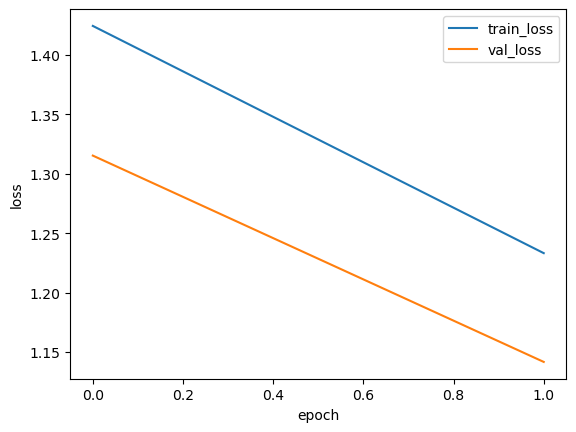

<Figure size 640x480 with 0 Axes>

In [31]:
# 保存loss图像
plt.plot(range(len(train_loss_list)), train_loss_list, label="train_loss")
plt.plot(val_epoch_list, val_loss_list, label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.clf()

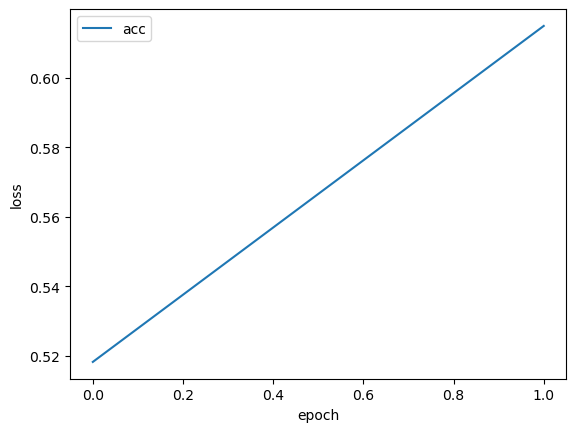

<Figure size 640x480 with 0 Axes>

In [32]:

plt.plot(range(len(val_acc_list)), val_acc_list, label="acc")

plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.clf()